In [11]:
import torch, numpy as np
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as Data


from plots import plot_admm_vs_admm_1d_reconstruction

torch.manual_seed(0)

torch.set_default_dtype(torch.float64)

## Data
Next, we generate a data set $\mathcal{D}=\{(\boldsymbol{s}_t, \boldsymbol{x}_t)\}_{t=1}^{n_t}$, where each $\boldsymbol{s}_t$ has $m=200$ entries, out of which at most $k=4$ are non-zero, while $\boldsymbol{x}_t$ has $n=150$ entires and is obtained via
\begin{equation}
\boldsymbol{x}_t = \boldsymbol{H}\boldsymbol{s}_t + \boldsymbol{w}_t,
\end{equation}
with $\boldsymbol{w}_t$ being i.i.d. Gaussian noise.

To that aim, we generate a dedicated class inheriting Dataset to get the data samples, and to allow each tuple to be comprised of both $(\boldsymbol{s}_t, \boldsymbol{x}_t)$ as well as $\boldsymbol{H}$.

In [12]:
class SimulatedData(Data.Dataset):
    def __init__(self, x, H, s):
        self.x = x
        self.s = s
        self.H = H

    def __len__(self):
        return self.x.shape[1]

    def __getitem__(self, idx):
        x = self.x[:, idx]
        H = self.H
        s = self.s[:, idx]
        return x, H, s

The next function creates a dataset.


In [13]:
def create_data_set(H, n, m, k, N=1000, batch_size=512, snr=30, noise_dev=0.5):
    # Initialization

    x = torch.zeros(n, N)
    s = torch.zeros(m, N)
    # Create signals
    for i in range(N):
        # Create a sparsed signal s
        index_k = np.random.choice(m, k, replace=False)
        peaks = noise_dev * np.random.randn(k)

        s[index_k, i] = torch.from_numpy(peaks).to(s)

        # X = Hs+w
        x[:, i] = H @ s[:, i] + 0.01 * np.random.randn(n)

    simulated = SimulatedData(x=x, H=H, s=s)
    data_loader = Data.DataLoader(dataset=simulated, batch_size=batch_size, shuffle=True)
    return data_loader

Finally, we generate the data set


In [14]:
n, m, k = 150, 200, 4

# Measurement matrix
H = torch.randn(n, m)
H /= torch.norm(H, dim=0)

train_loader = create_data_set(H, n=n, m=m, k=k, N=1000)

test_loader = create_data_set(H, n=n, m=m, k=k, N=1000)

Vanilla ADMM implementation

In [15]:
def vanilla_admm(x, H, lambda_=12.5, mu=0.00005, rho=0.01, max_itr=300, eps=10 ** -5):
    proj = torch.nn.Softshrink(rho / (2 * lambda_))

    # initial estimate
    s = torch.zeros((H.shape[1]))
    u = torch.zeros((H.shape[1]))
    v = torch.zeros((H.shape[1]))

    # left_term = (H^TH+2λI)^-1 2*lambda or rho?
    left_term = torch.linalg.inv(H.T @ H + rho * torch.eye(H.shape[1]))

    recovery_errors = []
    for k in range(max_itr):
        s_prev, v_prev, u_prev = s, v, u

        # Update s_k+1 = ((H^T)H+2λI)^−1(H^T x+2λ(vk−uk)).

        right_term = H.T @ x + rho * (v_prev - u_prev)
        s = left_term @ right_term

        # Update vk+1 = prox_(1/2λϕ)(sk+1 + uk)
        v = proj(s + u_prev)

        # Update uk+1 = uk + μ (sk+1 − vk+1).

        u = u_prev + mu * (s - v)

        # # cease if convergence achieved
        if torch.sum(torch.abs(s - s_prev)) <= eps:
            break

        # save recovery error
        recovery_errors.append(torch.sum((torch.matmul(H, s) - x) ** 2))

    return s

1D Model Based ADMM implementation

In [16]:
EPSILON = 10 ** -2

class LADMM_Model_1D(nn.Module):
    def __init__(self, n, m, max_iterations=1000, rho=0.01, H=None, lambda_=12.5, mu=0.00005, epsilon=EPSILON):
        super(LADMM_Model_1D, self).__init__()
        self.n, self.m = n, m
        self.H = H

        # admm(x, H, lambda_=12.5, mu=0.00005, rho=0.01, max_itr=300, eps=10 ** -5):

        # Initialization of 1 dimensional parameter
        self.rho = nn.Parameter(torch.ones(1) * rho, requires_grad=True)
        self.lambda_ = nn.Parameter(torch.ones(1) * lambda_, requires_grad=True)
        self.mu = nn.Parameter(torch.ones(1) * mu, requires_grad=True)

        self.max_iteration = max_iterations
        self.epsilon = epsilon

    def _shrink(self, s, beta, rho):
        return beta * F.softshrink(s / beta, lambd=rho)

    def forward(self, x):
        """
        Args:
            x:
        Returns:
        """

        s_prev = torch.zeros(x.shape[0], self.H.shape[1])
        u_prev = torch.zeros((x.shape[0], self.H.shape[1]))
        v_prev = torch.zeros((x.shape[0], self.H.shape[1]))

        #################### Iteration 0 ####################

        left_term = torch.linalg.inv(H.T @ H + self.rho * torch.eye(H.shape[1]))

        right_term = (H.T @ x.T).T + self.rho * (v_prev - u_prev)

        s = (left_term @ right_term.T).T
        v = self._shrink(s + u_prev, self.rho / (2 * self.lambda_), rho=self.rho.item())
        u = u_prev + self.mu * (s - v)

        ######################################################
        iteration = 0

        # Notice the stopping condition isn't fixed K iterations
        while (torch.norm(s_prev.detach() - s.detach()).item() > self.epsilon) and (iteration < self.max_iteration):
            s_prev, v_prev, u_prev = s, v, u

            # left_term = (H^TH+2λI)^-1 2*lambda or rho?
            left_term = torch.linalg.inv(H.T @ H + self.rho * torch.eye(H.shape[1]))

            right_term = (H.T @ x.T).T + self.rho * (v_prev - u_prev)

            # Update s_k+1 = ((H^T)H+2λI)^−1(H^T x+2λ(vk−uk)).
            s = (left_term @ right_term.T).T

            # Update vk+1 = prox_(1/2λϕ)(sk+1 + uk)
            v = self._shrink(s + u_prev, self.rho / (2 * self.lambda_), rho=self.rho.item())

            # Update uk+1 = uk + μ (sk+1 − vk+1).
            u = u_prev + self.mu * (s - v)
            iteration += 1

        print("Batch total iterations: {0}, parameters: mu:{1} lambda:{2} rho:{3}".format(iteration, self.mu.item(),
                                                                                          self.lambda_.item(),
                                                                                          self.rho.item()))
        return s

## Train and Validation

For training, we use SGDM with learning rate scheduler and the $\ell_2$ loss

In [17]:
def train(model, train_loader, valid_loader, num_epochs=60):
    """Train a network.
    Returns:
        loss_test {numpy} -- loss function values on test set
    """
    # Initialization
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=5e-05,
        momentum=0.9,
        weight_decay=0,
    )

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
    loss_train = np.zeros((num_epochs,))
    loss_test = np.zeros((num_epochs,))

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for step, (b_x, b_H, b_s) in enumerate(train_loader):

            s_hat = model(b_x)
            loss = F.mse_loss(s_hat, b_s, reduction="sum")
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            model.zero_grad()
            train_loss += loss.data.item()

        # Aggregate loss
        loss_train[epoch] = train_loss / len(train_loader.dataset)
        scheduler.step()

        # Validation
        model.eval()
        test_loss = 0
        for step, (b_x, b_H, b_s) in enumerate(valid_loader):
            s_hat = model(b_x)
            test_loss += F.mse_loss(s_hat, b_s, reduction="sum").data.item()
        loss_test[epoch] = test_loss / len(valid_loader.dataset)

        if epoch % 10 == 0:
            print("Epoch %d, Train loss %.8f, Validation loss %.8f" % (epoch, loss_train[epoch], loss_test[epoch]))

    return loss_test, b_x, b_s

The following functions apply 1D L-ADMM and ADMM for given data sets

In [18]:
def admm_1d_apply(train_loader, test_loader, max_iterations, H):
    n = H.shape[1]
    m = H.shape[1]

    ladmm = LADMM_Model_1D(n=n, m=m, max_iterations=max_iterations, H=H)

    loss_test, b_x, b_s = train(ladmm, train_loader, test_loader)
    error = loss_test[-1]

    return error, ladmm, b_x, b_s


def admm_apply(test_loader, T, H):

    loss = 0

    for step, (x, _, s) in enumerate(test_loader.dataset):
        s_hat = vanilla_admm(x=x, H=H, max_itr=T)
        loss += F.mse_loss(s_hat, s, reduction="sum").data.item()

    return loss / len(test_loader.dataset)

In [19]:
max_iter, epochs = 1000, 60

# Train and apply L-ADMM One Parameter with T iterations / layers. b_x, b_s are a batch from the validation set
ladmm_mse, admm1d_model, b_x, b_s = admm_1d_apply(train_loader, test_loader, max_iter, H)

admm_mse = admm_apply(test_loader, max_iter, H)

######################### Visuallization #########################
b_x, s_gt = b_x[0], b_s[0]
s_hat_ladmm = admm1d_model(b_x)
s_hat_ladmm = s_hat_ladmm.detach().numpy()[0]

s_hat_admm = vanilla_admm(x=b_x, H=H, max_itr=max_iter)

plot_admm_vs_admm_1d_reconstruction(s_hat_admm=s_hat_admm,
                                  s_hat_ladmm=s_hat_ladmm, max_iter=max_iter,s_gt = s_gt, epochs=epochs)



Epoch 0, Train loss 0.29424693, Validation loss 0.29103251
Epoch 10, Train loss 0.01007987, Validation loss 0.00785915
Epoch 20, Train loss 0.00228258, Validation loss 0.00229867
Epoch 30, Train loss 0.00231482, Validation loss 0.00233214
Epoch 40, Train loss 0.00228590, Validation loss 0.00230324
Epoch 50, Train loss 0.00226444, Validation loss 0.00228566


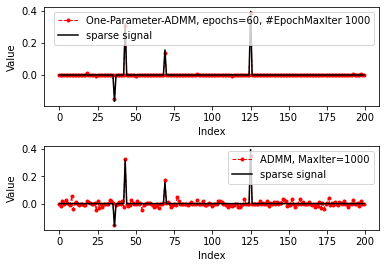

In [20]:
plot_admm_vs_admm_1d_reconstruction(s_hat_admm=s_hat_admm,
                                    s_hat_ladmm=s_hat_ladmm,
                                    max_iter=max_iter, s_gt = s_gt, epochs=epochs)